# WebSockets and Real-time Communication

WebSocket is a **persistent, bidirectional, full-duplex communication protocol** that operates over a [**single TCP**](../session-8-http-and-flask/0_http_and_flask.ipynb) connection.

Key Characteristics   
- **Persistent Connection**: Once established, stays open until explicitly closed
- **Bidirectional**: Both client and server can send messages independently
- **Low Latency**: No overhead of establishing new connections for each message
- **Real-time**: Instant message delivery without polling

TCP: transmission control protocal, birectional itself, ensures reliability, but lack of real-time ability (low speed).    

UDP: prioritizes speed over guaranteed delivery.   

![websocket](./pic/websocket.png)


## WebSocket vs HTTP Polling vs Long Polling vs SSE  
> If interviewee ask about real-time:
> Mostly, use WebSocket, which is supportted by most of web servers. 

| Feature | HTTP Polling | Long Polling | SSE (Server-Sent Events) | WebSocket | 
|---------|-------------|--------------|-----------|-----------|
| Connection | New connection per request | Held open until data | One long-lived connection (server → client)| Persistent connection |
| Direction|Client → Server|Client → Server|**Server → Client only**|Client ↔ Server (full duplex)|
| Latency | High (constant requests) | Medium| Low | Very Low |
| Server Load | High (many requests) | Medium | Low | Low |
| Overhead | High (HTTP headers) | Medium | Low | Very Low |
|Scalability|Poor|Medium|Good|Medium/Good (but heavier state)|
|Reconnect Handling|Manual|Manual|Built-in auto-reconnect|Manual/Library|
|Browser Support|Excellent|Excellent|Excellent (except old IE)|Excellent|
| Use Case | Infrequent updates | Moderate real-time |Real-time streaming push| True real-time bidirectional apps|



**HTTP Polling**: Client repeatedly requests server at intervals   

Client sends a request every X seconds regardless of updates:

```text
Client → Server: "Any updates?" (every 5s)
Server → Client: "No"
Client → Server: "Any updates?"
Server → Client: "No"
```
*Pros*: Simple   
*Cons*: Wasteful; high latency; heavy load   

**Long Polling**: Server holds request, keeps it open until new data available

```text
Client → Server: "Any updates?"
... (server waits)
Server → Client: "Yes, here's data"
Client → Server: "Any updates?" (reconnect)
```
*Pros*: Lower latency than polling     
*Cons*: Still requires reconnections

**SSE (Server-Sent Events)**: Client opens one streaming HTTP connection, server pushes events when available  

```text
Client → Server: "Open EventSource connection"
Server → Client: "event: message\ndata: {...}"
Server → Client: "event: message\ndata: {...}"
... (stream continues)
```

*Pros*:  
- Built-in reconnection
- Lightweight
- Perfect for one-way event streams

*Cons*:   
- Server → client only (not two-way)    
- Not binary (text only)    

**WebSocket**: Client and server maintain a persistent, full duplex connection

```text
Client ↔ Server: [Handshake - establish connection]
Client → Server: Message
Server → Client: Message
... (connection stays open)
```
*Pros*:
- Real-time bidirectional
- Lowest latency
- Ideal for chats, multiplayer, trading apps     
  
*Cons*:
- More complex
- Requires stateful connections at scale

## WebSocket Connection Flow

1. **Initial HTTP Handshake** (Upgrade request)

```text
GET /ws HTTP/1.1
Host: localhost:8000
Upgrade: websocket
Connection: Upgrade
```

2. **Server Response** (Upgrade acceptance)
```text
HTTP/1.1 101 Switching Protocols
Upgrade: websocket
Connection: Upgrade
```

3. **WebSocket Connection Established**
- Bidirectional communication begins
- Messages flow freely in both directions


## FastAPI WebSocket Implementation
**FastAPI**: **Built-in WebSocket** support    

Django: 
- Standard Django (WSGI) cannot handle WebSockets, only HTTP requests
- WebSocket support requires Django Channels (pip install channels)
- Requires ASGI server (like Daphne or Uvicorn) instead of WSGI

Flask:   
- does NOT natively support WebSockets (it’s WSGI-based)
- use Flask-SocketIO (most common)
	- Provides WebSocket-like real-time support
	- Works with eventlet or gevent servers
- or use an ASGI server + Quart (Flask-like, but ASGI and WebSocket support)

So here we are gonna use FastAPI    

To build a real-time chat box (when open several windows, can reveive same chat content):  
1. frontend: [index.html](./static/index.html)   

this is the Client Side using JavaScript in process the connection

2. backend: [websocket.py](./websocket.py)
   
this is the server side, which is what we care about


### Server Side (Python/FastAPI)
```python
# websocket.py
from fastapi import FastAPI, WebSocket
from fastapi.staticfiles import StaticFiles
import json

app = FastAPI()

# Store all connected clients
connected_clients = []

# websocket endpoint, not a normal one
@app.websocket('/ws')
async def websocket_endpoint(websocket: WebSocket):
    # 1. Accept connection
    await websocket.accept()
    print('Client Connected')
    
    # 2. Add to connected clients list
    connected_clients.append(websocket)
    
    try: 
        # 3. Receive and broadcast messages
        while True:
            # receive data
            data = await websocket.receive_text()
            message = json.loads(data)
            print(f'message received {message}')

            # # Sent to one client
            # await websocket.send_json({
            #     "type": "message",
            #     "text": f'message: {message} received'
            # })

            # Broadcast to all connected clients
            for client in connected_clients:
                await client.send_json({
                    "type": "message",
                    "text": message['text']
                })
                
    except Exception as e:
        print('error', e)
    
    # if disconnect
    finally:
        # 4. Clean up 
        connected_clients.remove(websocket)
        
        # Notify others that client left (like a chat room)
        for client in connected_clients:
            await client.send_json({
                "type": "notification",
                "text": "A client left"
            })

# Serve static HTML files
app.mount("/", StaticFiles(directory="static", html=True), name="static")
```



## WebSocket States (optional)

The WebSocket object in JavaScript has a readyState property that indicates the current state of the connection. It can have one of four numeric values:   
```javascript
ws.readyState === WebSocket.CONNECTING  // 0
ws.readyState === WebSocket.OPEN        // 1
ws.readyState === WebSocket.CLOSING     // 2
ws.readyState === WebSocket.CLOSED      // 3
```
Quick Lifecycle Example   
```javascript
const ws = new WebSocket("ws://localhost:8000/ws");

ws.onopen = () => console.log("Connection opened");   // state = 1
ws.onmessage = (e) => console.log("Message:", e.data);
ws.onclose = () => console.log("Connection closed");   // state = 3
ws.onerror = (err) => console.error("WebSocket error", err);

console.log(ws.readyState); // 0 (CONNECTING)
```

Lifecycle flow:    
0 (CONNECTING) → 1 (OPEN) → 2 (CLOSING) → 3 (CLOSED)    

💡 Tips
- Always check readyState before sending messages to avoid errors.
- Use onclose to trigger reconnection logic if needed.
- Remember CLOSING (2) is transient; messages sent here will fail.
- readyState is read-only; you cannot manually change it.

## Use Cases for WebSockets
- **Chat Applications**: Real-time messaging
- **Live Feeds**: Social media updates, news feeds
- **Collaborative Tools**: Google Docs-style editing
- **Gaming**: Multiplayer real-time games
- **Financial Tickers**: Stock price updates
- **Notifications**: Push notifications
- **IoT Dashboards**: Sensor data streaming



## Best Practices
1. **Always handle disconnections** - Clients can disconnect unexpectedly
2. **Implement reconnection logic** - Auto-reconnect with exponential backoff
3. **Use heartbeat/ping-pong** - Detect dead connections
4. **Validate messages** - Sanitize and validate all incoming data
5. **Handle connection limits** - Don't store too many connections in memory
6. **Consider horizontal scaling** - Use Redis pub/sub for multi-server setups

---



# Caching Strategies
**Why Cache?:**   
- **Reduce Latency**: Serve data from memory (microseconds) vs database (milliseconds)
- **Reduce Database Load**: Fewer queries to database
- **Cost Savings**: Less database resource usage
- **Better User Experience**: Faster response times

## Stand-Alone Caching Server
**Why Stand-Alone Caching Server**:  
- A dedicated cache server can:
  - Store cache centrally (all threads & all servers access the same cache)
  - Handle concurrency safely
  - Scale independently from your main application servers
- Common choices: **Redis**, Memcached, etc.

previously, we have implemented caching decorator by using dictionary, but it is only suitable for single server's single service. It is not working for more than 2 threads. So a specific stand-alone caching server is needed.  

<img src="./pic/high-level-system-diagram.png" alt="caching_server" width="400"/>


### Redis
- Redis is an **in-memory key-value store**.
- Features:
  - **In-memory data store**: All data stored in RAM (very fast)
  - **Key-Value store**: Simple data model
  - **TTL support**: Automatic expiration
  - **Persistence options**: Can save to disk
  - **Data structures**: Strings, Lists, Sets, Hashes, Sorted Sets
- **Python integration**: Commonly used via redis-py.

#### Example using Redis for caching:
0. pip install redis 
1. run a Redis server in a Docker container
  ```bash
  docker run -d -p 6379:6379 redis
  # to close it, first find the name of container
  docker ps
  docker stop thirsty_hofstadter
  ```
2. create a decorator in [redis-cache.py](./redis-cache.py)
  ```python
    import redis
    import functools import wraps
    import time
    import json
    # connect the redis
    redis_client = redis.Redis(host='localhost', port=6379, db=0)

    def cachae(ttl=3600):
      def decorator(func):
          @wraps(func)
          def wrapper(*args, **kwargs):
              key = f"{func.__name__}:{args}:{kwargs}"
              cached = redis_client.get(key)
              
              if cached:
                print('[Cache HIT]')
                return json.loads(cached)
              
              print('[Cache MISS]')
              result = func(*args, **kwargs)
              redis_client.set(key, json.dumps(result), ttl)
              return result
          return wrapper
      return decorator
  ```

calling it the first time costs more time than later:

In [4]:
! python redis-cache.py

[Cache MISS]
fetch from database...
{'user_id': 1}
Time used: 2.0190 seconds
[Cache HIT]
{'user_id': 1}
Time used: 0.0019 seconds
[Cache HIT]
{'user_id': 1}
Time used: 0.0029 seconds


#### Redis Common Operations

```python
# String operations
redis_client.set('key', 'value', ex=3600)  # Set with TTL
value = redis_client.get('key')             # Get
redis_client.delete('key')                   # Delete

# Hash operations (for objects)
redis_client.hset('user:1', mapping={'name': 'Alice', 'age': 30})
user = redis_client.hgetall('user:1')

# List operations (for queues)
redis_client.lpush('queue', 'task1')  # Push to head
task = redis_client.rpop('queue')      # Pop from tail

# Set operations (for unique items)
redis_client.sadd('tags', 'python', 'redis')
members = redis_client.smembers('tags')

# Sorted set (for leaderboards)
redis_client.zadd('leaderboard', {'alice': 100, 'bob': 200})
top = redis_client.zrevrange('leaderboard', 0, 9)  # Top 10
```



## Cache Decision Tree

```text
Should we cache this?

1. Does it change often?
   ├─ YES (changes every second) → Don't cache
   └─ NO (changes daily/weekly) → Consider caching

2. Is it expensive to fetch?
   ├─ YES (complex joins, multiple queries) → Cache it
   └─ NO (simple lookup) → Doesn't matter

3. Is it accessed frequently?
   ├─ YES (100x per minute) → Definitely cache
   └─ NO (once a day) → Probably not worth it
```



## [Top 5 Caching Patterns](./pic/top-5-caching-strategies.png)

<img src="./pic/top-5-caching-strategies.png" alt="caching_strategies" width="700"/>


### 1. Cache-Aside (Lazy Loading)
**Most Common Pattern**
> Usually interviwee won't ask so detail     
> If ask, just use this most common one

**Flow**:
1. Application checks cache first
2. **Cache Miss** → Read from database → Update cache
3. **Cache Hit** → Return cached data

**Pros**:
- Update logic is at application level (easy to implement)
- Cache only contains what application requests (no unnecessary data)

**Cons**:
- Each cache miss results in 3 trips (check cache, read DB, update cache)
- Data may be stale if DB is updated directly


### 2. Read-Through
**Application reads through cache layer**

**Flow**:
1. Application reads from cache
2. Cache automatically fetches from DB if miss
3. Cache manages all data access logic

**Pros**:
- Application logic is simple (just query cache)
- Only one query hits the DB on cache miss

**Cons**:
- Data access logic is in the cache (needs plugin/library)
- More complex setup



### 3. Write-Around
**Write to DB, read from cache**

**Flow**:
1. Write directly to database
2. On read: Check cache → If miss, read from DB and update cache

**Pros**:
- DB is source of truth
- Lower write latency (no cache update on write)

**Cons**:
- Higher write latency (must write to DB first)
- Cache data may be stale until read



### 4. Write-Back (Write-Behind)
**Write to cache first, DB later**

**Flow**:
1. Write to cache immediately (fast)
2. Asynchronously write to DB later (batched)

**Pros**:
- Very low write latency
- Can batch DB writes
- Cache and DB are eventually consistent

**Cons**:
- <font color=red>Risk of data loss</font> if cache goes down before DB write
- Complex implementation
- Infrequent data also stored in cache



### 5. Write-Through
**Write to cache and DB simultaneously**

**Flow**:
1. Write to cache
2. Cache immediately writes to DB

**Pros**:
- Cache and DB are in sync
- Reads have lower latency (data already cached)

**Cons**:
- Higher write latency (must wait for DB write)
- Infrequent data is also cached



### Comparison

| Pattern | Write Latency | Read Latency | Consistency | Data Loss Risk |
|---------|--------------|--------------|-------------|----------------|
| Cache-Aside | Low | Medium | Eventually | None |
| Read-Through | Low | Low | Eventually | None |
| Write-Around | Medium | Medium | Eventually | None |
| Write-Back | Very Low | Low | Eventually | **HIGH** |
| Write-Through | High | Low | Strong | None |

When to Use Each Pattern:  

**Cache-Aside**: 
- Most common, default choice
- Read-heavy workloads
- Data changes infrequently

**Read-Through**:
- Want to hide cache complexity from application
- Have library support

**Write-Around**:
- Write-heavy, read data once
- Don't want to pollute cache

**Write-Back**:
- Need ultra-low write latency
- Can tolerate data loss
- High write throughput needed

**Write-Through**:
- Need strong consistency
- Read-heavy after writes
- Can tolerate write latency


## Cache Invalidation Strategies

**1. TTL (Time To Live)**  
Automatically expires cache entries after a fixed period.
- Pros: Simple to implement; avoids stale data over time.
- Cons: Data might be slightly stale until TTL expires; choosing the right TTL can be tricky.

```python
# Expire after 5 minutes
redis_client.set('user:1', data, ex=300)
```

Best for data that changes infrequently or where slight staleness is acceptable.

**2. Event-based Invalidation**  
Explicitly remove or update cache when the underlying data changes.
- Pros: Keeps cache consistent with the database; good for critical or frequently updated data.
- Cons: Requires extra logic to track updates; risk of missing invalidations if not handled properly.

```python
# Delete cache when data updates
def update_user(user_id, data):
    db.update(user_id, data)
    redis_client.delete(f'user:{user_id}')
```
Works well when you have control over all data modifications.  

**3. Version-based** (Cache Key Versioning)  
Include a version number in the cache key; increment version on data changes.
- Pros: Simplifies invalidation; old cache entries automatically ignored.
- Cons: Old cache data still occupies memory until it expires.

```python
# Include version in cache key
cache_key = f'user:{user_id}:v{version}'
```

- When version increments, the cache key changes, effectively “invalidating” the old cached data.
- Useful when you want to avoid deleting old cache immediately or when multiple clients may update the data asynchronously.



## Cache Performance Metrics

**Hit Ratio** = Cache Hits / (Cache Hits + Cache Misses)
- Good: > 80%
- Excellent: > 95%

**Eviction Rate** = Keys evicted / Total keys   
Monitor to ensure cache isn't too small
- Keys Evicted: Number of keys the cache removed automatically due to memory pressure  
- Total Keys: Total number of keys currently in the cache (or total keys ever added, depending on monitoring).  
- **High eviction rate**: your cache cannot hold all the needed data; Redis keeps removing keys, causing cache misses and forcing the app to fetch from the slower database.
- **Low eviction rate**: your cache is big enough, and eviction is rare 
- 💡 Tip: For a healthy cache, you generally want eviction rate to be **very low or zero**. Occasional evictions are fine if the data can be easily recomputed or refetched.  


Keys Eviceted usually happens when the cache reaches its maximum memory limit and needs to make room for new entries.   

How it helps in practice  
- Helps decide if you need to increase cache memory.
- Helps decide if you need to optimize your caching strategy, e.g., use TTLs, LRU, or LFU policies.
- Ensures your cache is effective without wasting memory.


---



# Message Queues and Background Tasks

What are Message Queues?   

<img src="./pic/msq-types.png" alt="msq" width="700"/> 

**Message Queue** = System for asynchronous communication between services/processes

**Key Concepts**:
- **Producer**: Sends messages to queue
- **Consumer/Worker**: Processes messages from queue
- **Queue**: Stores messages until processed
- **Broker**: Manages queues (**RabbitMQ, Kafka, Redis**)

Why Use Message Queues?      

1. **Asynchronous Processing**: Don't block user while processing
2. **Decoupling**: Services don't need to know about each other
3. **Load Leveling**: Handle traffic spikes by queuing
4. **Reliability**: Retry failed tasks automatically
5. **Scalability**: Add more workers to process faster

<font color=red>Not all system need message queues.</font>   
Message queues are powerful, but they add complexity, cost, and operational overhead. Many systems work perfectly without them.  

When You **Do NOT Need a Message Queue**:  

1. Your system is simple (CRUD apps):    
   Typical web apps (e.g., Django, FastAPI, Flask, Rails) that just handle HTTP requests, read/write from a database, and return a response.   
2. Your operations are fast enough to run inline:   
   If your tasks take milliseconds or a few hundred milliseconds, just run them during the request/response, no need to async them out via MQ.
3. You don’t need decoupling between services:   
   Only have one service, or services can call each other directly via REST or gRPC, so no need that message queues introduce asynchronous communication
4. You don’t process huge traffic:   
   If your workload is low or moderate, and your app/database can keep up
5. You don’t need reliable background processing:   
   If failures are rare and retries aren’t mission-critical

## Message Queue Patterns

### 1. Point-to-Point (1→1)
- One message → One consumer
- Message removed after consumption
- Use case: Task processing, job queues

```text
Producer → [Queue] → Consumer A
                   → Consumer B (gets different message)
```



### 2. Publish-Subscribe (1→Many)
- One message → Multiple consumers
- Message copied to all subscribers
- Use case: Notifications, event broadcasting

```text
Publisher → [Topic] → Subscriber A (gets copy)
                    → Subscriber B (gets copy)
                    → Subscriber C (gets copy)
```

Queue vs Topic 

| Why "Topic"? | Explanation| 
| ------------| -----------| 
| Describes content| Like newspaper topics, email subjects| 
| Natural language| "Subscribe to a topic" sounds natural| 
| Hierarchical| Topics can have sub-topics (like book chapters)| 
| Historical| Established by early messaging systems (1990s)| 
| Standardized| JMS formalized it in 2001| 

Physically (implementation): Topics often USE queues under the hood  
Conceptually (pattern): Topics and queues are different messaging patterns, the behavior is different:

**Point-to-Point Queue**:  
```text

         [Single Queue]
Producer → [M1, M2, M3] → Consumer A takes M1
                        → Consumer B takes M2
                        → Consumer C takes M3   
```
**Each message consumed ONCE and deleted**   

```python
# ONE message → ONE consumer
queue.send('tasks', 'process_order_123')
```

Worker A: Gets message → Processes → Done   
Worker B: Gets different message   
Worker C: Gets different message   
 


**Topic (Using Queues Internally)**:  
```text

                [Topic/Exchange]
Publisher  →         M1          
                     ↓
            ┌────────┼────────┐
            ↓        ↓        ↓
        [Queue1] [Queue2] [Queue3]    ← Physical queues!
           M1       M1       M1       ← Copied!
            ↓        ↓        ↓
         Sub A    Sub B    Sub C
```

**Each message copied to ALL subscribers    
Each subscriber has its own queue with a copy**  

```python
# ONE message → ALL subscribers (copied to their queues)
topic.publish('events', 'order_created_123')
```

Subscriber A: Gets copy → Processes → Done  
Subscriber B: Gets copy → Processes → Done    
Subscriber C: Gets copy → Processes → Done   




## Dead Letter Queue (DLQ)
A special queue that stores messages that failed to be processed successfully after multiple attempts.  

```text
Point-to-Point (Queue):  
Producer → [Main Queue] → Consumer A
                        → Consumer B
                            ↓ (fails 3x)
                       [Dead Letter Queue]

Publish-Subscribe (Topic) - Also Supported:  
Publisher → [Topic] → Subscriber A ✓ (success)
                    → Subscriber B ✗ (fails) → [DLQ for B]
                    → Subscriber C ✓ (success)

Each subscriber can have its own DLQ!
```

**Use Case** (Messages go to the DLQ when):
- **Max retries exceeded**: Failed processing 3+ times
- **Processing timeout**: Takes too long to process
- **Message is malformed**: Invalid JSON, missing required fields
- **Poison message**: Causes consumer to crash repeatedly
- **Business logic rejection**: Doesn't meet validation rules  

**Benefits** of DLQ:      
- **Don't Lose Data**  
  - Failed messages aren't deleted, they're preserved   
  - Can inspect them later to understand what went wrong     
- **Prevent Queue Blocking**  
  - Without DLQ, a "poison message" could block the entire queue   
  - Other valid messages can continue processing    
- **Debugging & Monitoring**    
  - View all failed messages in one place    
  - Analyze patterns (same error repeating?)    
  - Set up alerts when DLQ grows     
- **Replay Failed Messages**  
  - After fixing the bug, can move messages back to main queue   
  - Reprocess them successfully   

When **NOT to Use** DLQ:   
- **One-time events** that don't matter if lost (like analytics pings)
- **Already idempotent retries** handled elsewhere
- **Immediate feedback required** (can't wait for manual review)   

## Implementation

### RabbitMQ vs Kafka vs SQS

| Feature | RabbitMQ | Kafka | AWS SQS |
|---------|----------|-------|---------|
| **Type** | Traditional message broker | Distributed streaming | Cloud queue service |
| **Protocol** | AMQP | Custom | HTTP/HTTPS |
| **Ordering** | Yes (per queue) | Yes (per partition) | Best effort (FIFO queues available) |
| **Persistence** | Optional | Always (disk) | Always |
| **Performance** | ~20K msg/sec | ~1M+ msg/sec | Variable |
| **Replay** | No | Yes (time-based) | No |
| **Use Case** | Task queues, RPC | Event streaming, logs | Simple queues, AWS integration |
| **Message TTL** | Yes | Retention period | Yes |
| **Delivery** | At-most-once, At-least-once | At-least-once, Exactly-once | At-least-once |

**When to use**:
- **RabbitMQ**: Traditional task queues, job processing, microservices communication
- **Kafka**: Event streaming, log aggregation, real-time analytics, high throughput
- **SQS**: AWS ecosystem, simple queues, serverless architectures



### Celery + RabbitMQ
Celery is a distributed task queue system that lets you:
- run tasks asynchronously
- run tasks in the background
- schedule periodic jobs
- distribute work across multiple workers

Celery handles task execution, retries, workers, task routing, task serialization, etc.  

```text
Your App (Django/FastAPI/etc)
        |
        | send task
        v
    Message Broker (Redis/RabbitMQ)
        |
        | pull & execute
        v
   Celery Workers
```

- Your app pushes a task message to the broker that is the queue manager.
- Celery workers read from the broker and execute tasks.

#### 0. Setup
Install Celery and Redis
```bash
# Install dependencies
uv pip install celery redis
```

**Start RabbitMQ (message broker)**
```bash
# If not exist
docker run -d --name rabbitmq -p 5672:5672 -p 15672:15672 rabbitmq:3-management
# Start the existing rabbitmq container
docker start rabbitmq
```

**Start Redis (result backend)**
```bash
docker run -d -p 6379:6379 redis
```

**RabbitMQ Management UI** at http://localhost:15672/    
Default login: guest/guest    
<img src="./pic/rabbitMQ_MngtUI.png" alt="rabbitMQ" width="500"/> 

#### [1. Producer (FastAPI Server)](./message_queue.py)
```python
# message_queue.py
from fastapi import FastAPI
from celery import Celery
import uuid
from .message_consumer import process_order

# Configure Celery
app_celery = Celery(
    'orders',
    broker='amqp://localhost',   # RabbitMQ
    backend='rpc://'             # RPC backend for results
)

app_celery.conf.update(
    task_serializer="json",
    accept_content=['json'],
    result_serializer='json'
)

app = FastAPI()

@app.post('/orders')
def create_order(customer: str, amount: float):
    """Create order and queue for processing"""
    order_id = str(uuid.uuid4())[:10]
    # # BLOCKS for 2 seconds! User waits...
    # result = process_order(order_id, customer, amount)
    # return result

    # Send task to queue (async, non-blocking)
    task = process_order.delay(order_id, customer, amount)
    
    return {
        'status': 'processing',
        'order_id': order_id,
        'task_id': task.id  # Track task status
    }
```

`.delay()`   
is Celery's magic method that transforms a synchronous function call into an asynchronous task.  

It takes 2s (simulating waiting time in process_order) for without it:
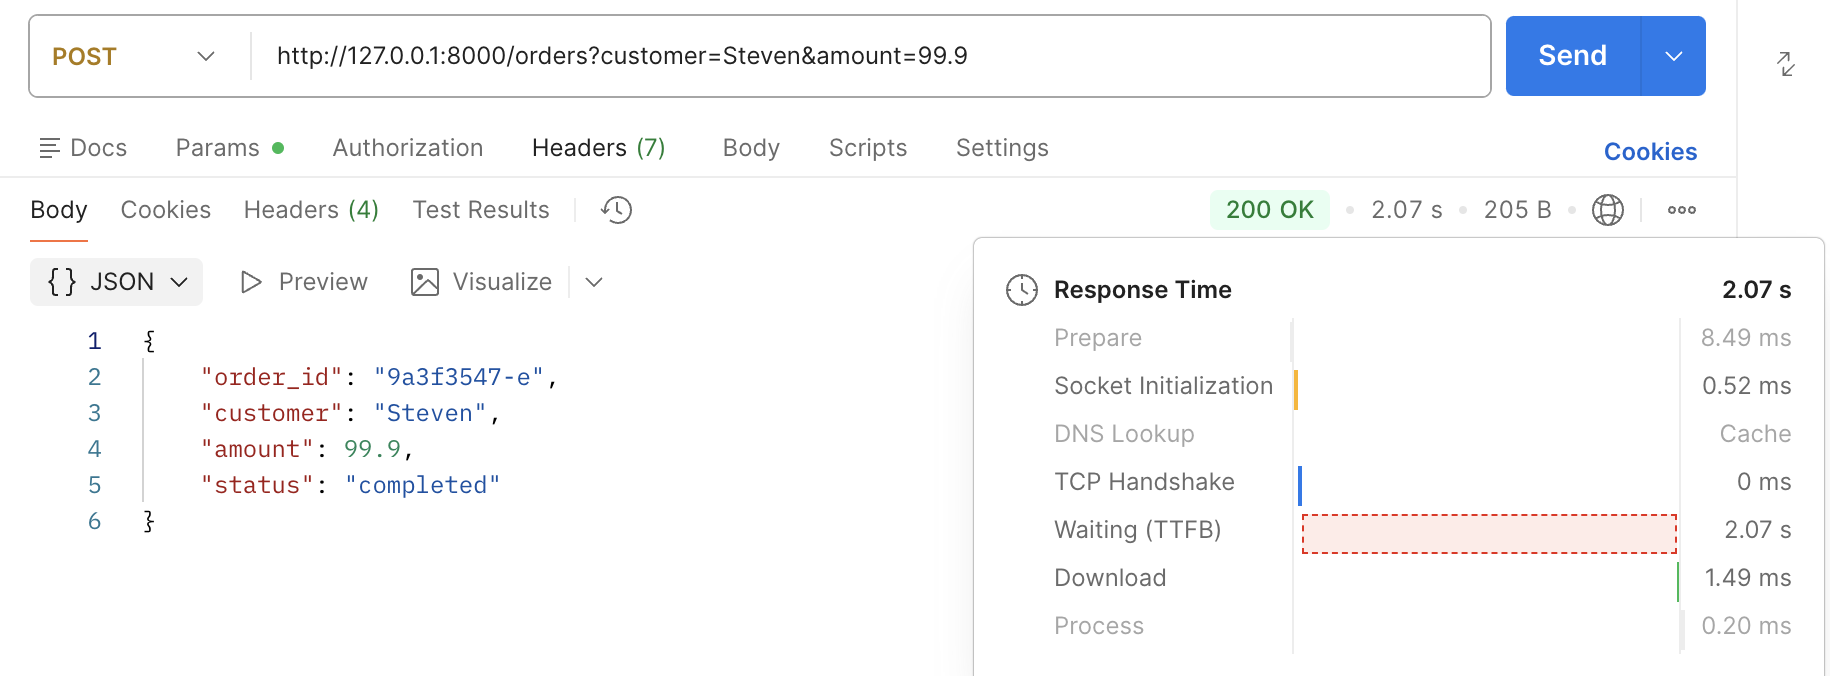

**Much faster put it into task queue**: 
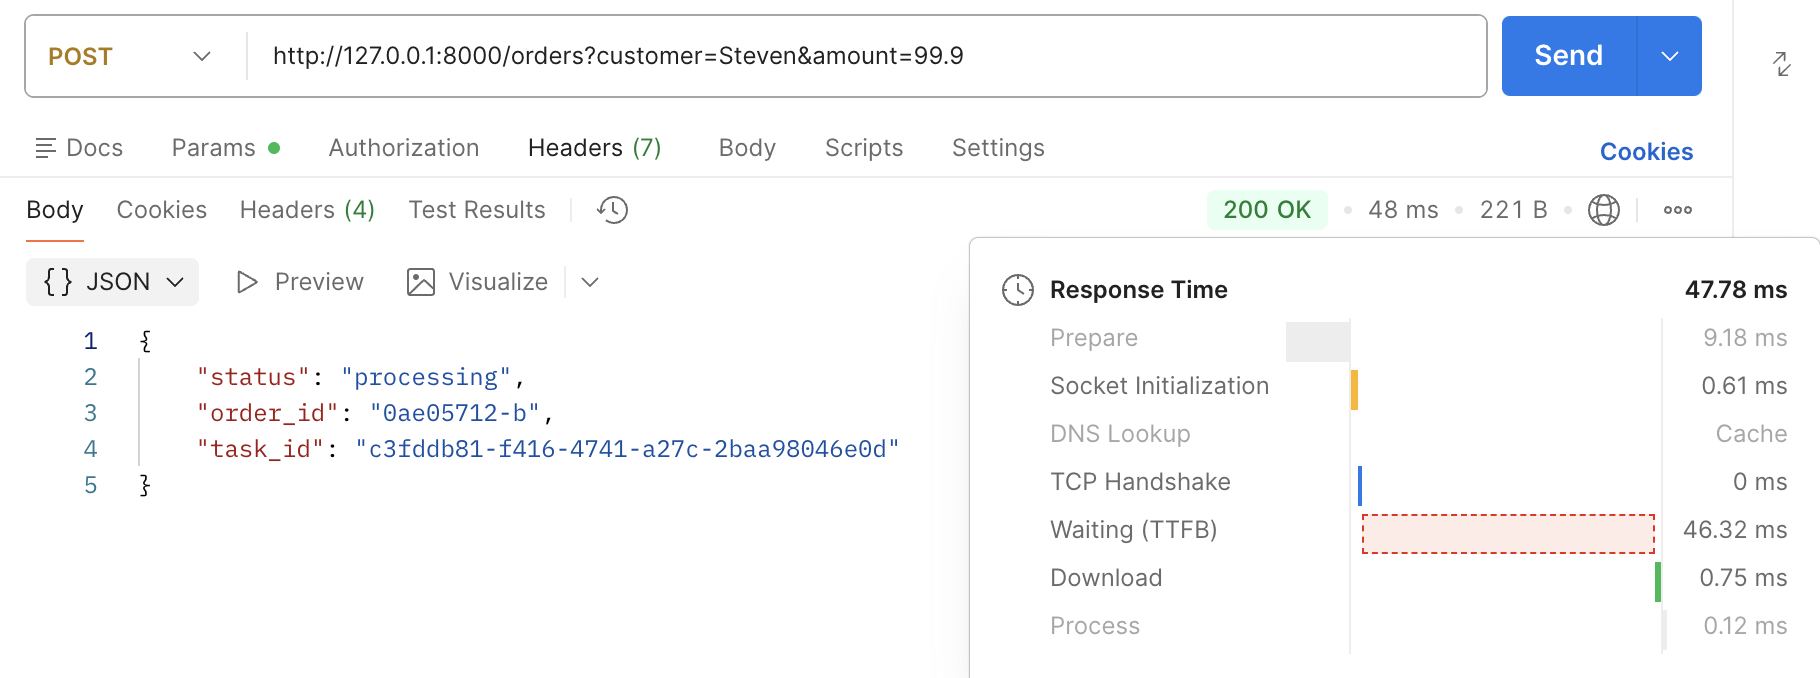

work flow:  
```text
User Request → [Instant response!] 
                      ↓
              Task queued in RabbitMQ
                      ↓
              Background worker processes it
                      ↓
              [2 seconds later] → Done
```

The AsyncResult Object

```python
task = process_order.delay(order_id, customer, amount)

# task is an AsyncResult object with these methods:

task.id              # 'abc123' - Unique task ID
task.state           # 'PENDING', 'STARTED', 'SUCCESS', 'FAILURE'
task.ready()         # False (still processing) or True (done)
task.successful()    # True if completed successfully
task.failed()        # True if failed
task.result          # The return value (blocks until done!)
task.get()           # Wait for result (blocking!)
task.get(timeout=5)  # Wait max 5 seconds
```

#### [2. Consumer (Celery Worker)](./message_consumer.py)
```python
from celery import Celery
import time
import redis

app_celery = Celery(
    'orders',
    broker='amqp://localhost',
    backend='rpc://'
)

app_celery.conf.update(
    task_serializer="json",
    accept_content=['json'],
    result_serializer='json'
)
# ↑ same as producer

redis_client = redis.Redis(host="localhost", port=6379, decode_responses=True)

@app_celery.task(name='process_order')
def process_order(order_id, customer, amount):
    """Process order (runs in background worker)"""
    
    # Check if already processed (idempotency)
    processed = redis_client.get(order_id)
    if processed:
        print(f'Order {order_id} already processed')
        return {'status': 'already_processed'}
    
    # Simulate long processing
    time.sleep(2)
    
    result = {
        'order_id': order_id,
        'customer': customer,
        'amount': amount,
        'status': 'completed'
    }
    
    # Mark as processed
    redis_client.set(order_id, "processed")
    
    print(f'Order {order_id} processed successfully')
    return result
```



#### 3. Running the System

```bash
# Terminal 1: Start Celery worker
celery -A message_consumer worker --loglevel=info
# or use Worker with auto-reload by using watchdog
watchmedo auto-restart --directory=./ --pattern=message_queue.py --recursive -- celery -A message_consumer worker --loglevel=info
# Now when you edit message_consumer.py, worker restarts automatically!

# Terminal 2: Start FastAPI server
fastapi dev message_queue.py

# Terminal 3: Send requests
curl -X POST "http://localhost:8000/orders" \
  -H "Content-Type: application/json" \
  -d '{"customer": "Alice", "amount": 99.99}'
```

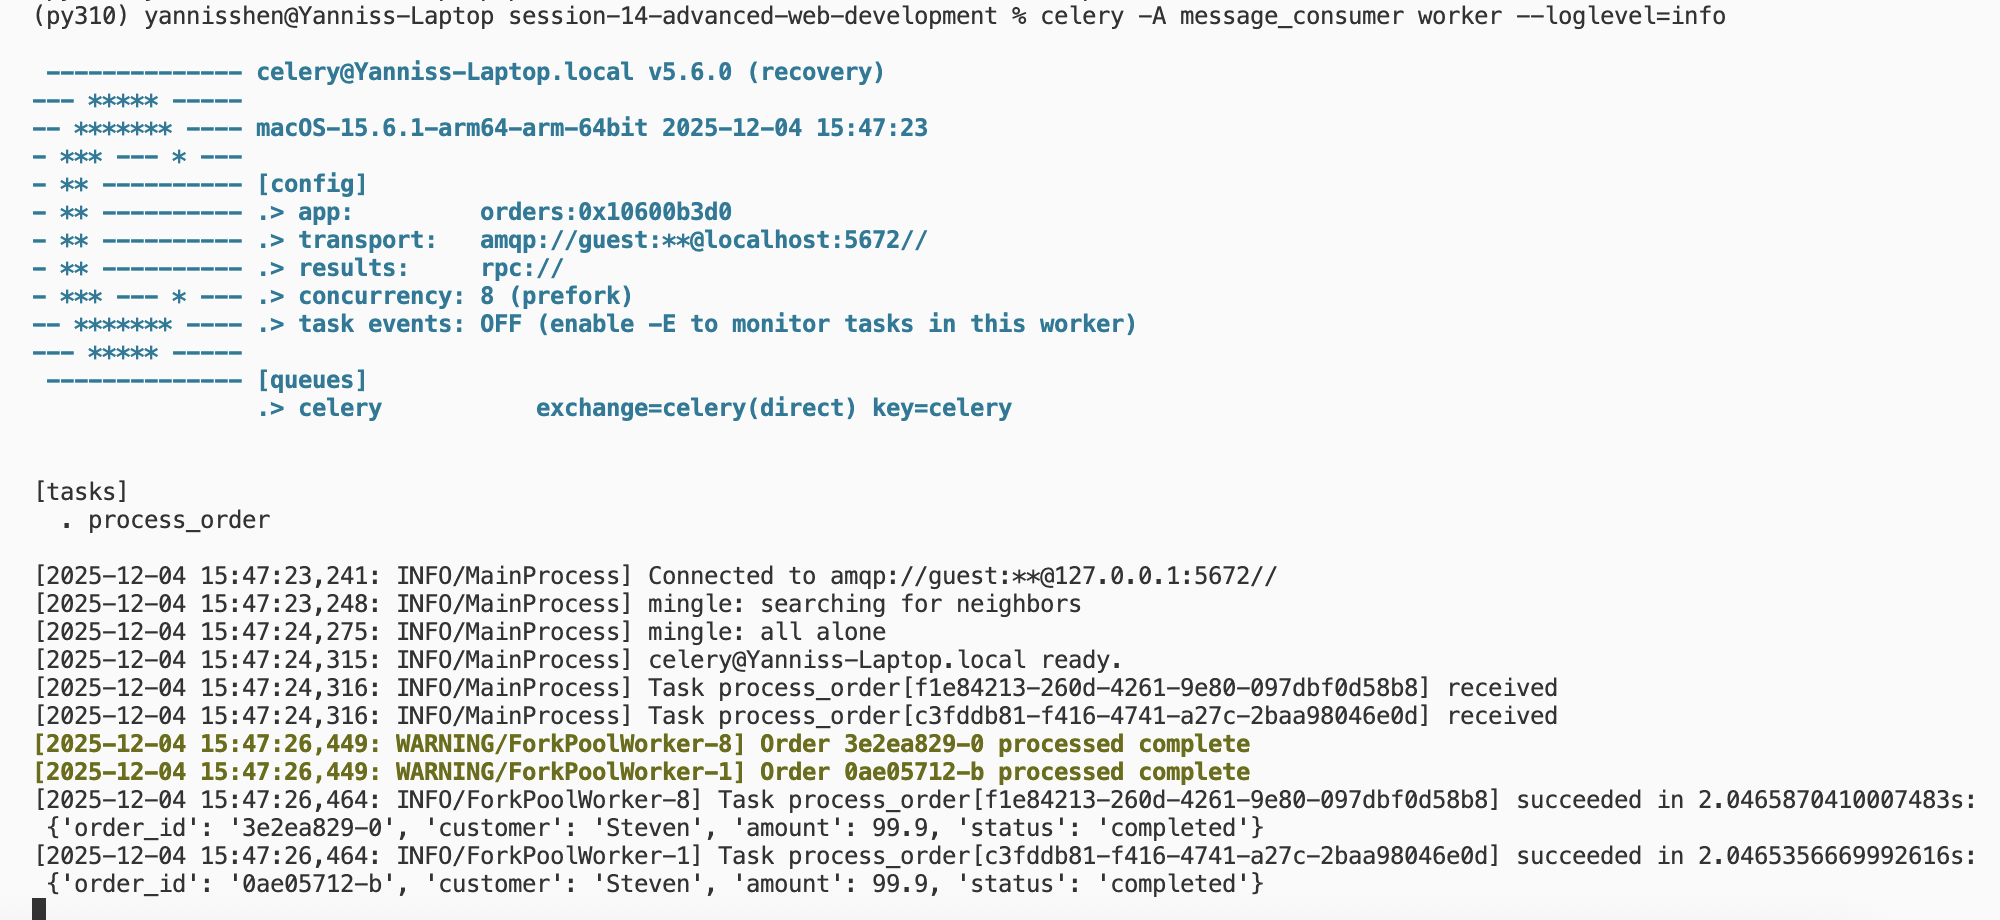



####  What Celery does behind the scenes:

```text
┌─────────────────────────────────────────────────────────┐
│ FastAPI Server (Web Process)                            │
│                                                         │
│  create_order()                                         │
│       ↓                                                 │
│  process_order.delay(...)  ← Celery's magic method      │
│       ↓                                                 │
│  task = AsyncResult(id='abc123')                        │
|  (Celery return AsyncResult object immediately)         |
│       ↓                                                 │
│  return {'task_id': 'abc123', 'status': 'processing'}   │
└───────────────┬─────────────────────────────────────────┘
                │ Sends message to queue 
                | rabbitmq.publish(queue='celery', message=message)
                ↓
┌───────────────────────────────────┐
│ RabbitMQ (Message Broker)         │
│                                   │
│ Queue: [task_abc123]              │
└───────────────┬───────────────────┘
                │ Worker picks up task
                ↓
┌───────────────────────────────────────────┐
│ Celery Worker (Background Process)        │
│                                           │
│  Receives: task_abc123                    │
│       ↓                                   │
│  Executes: process_order(...)             │
│       ↓                                   │
│  time.sleep(2)  ← Takes time, no problem! │
│       ↓                                   │
│  Returns: {'status': 'completed'}         │
│       ↓                                   │
│  Stores result in Redis                   │
└───────────────────────────────────────────┘
```

Postman Create Task and Check Status   
Start task:
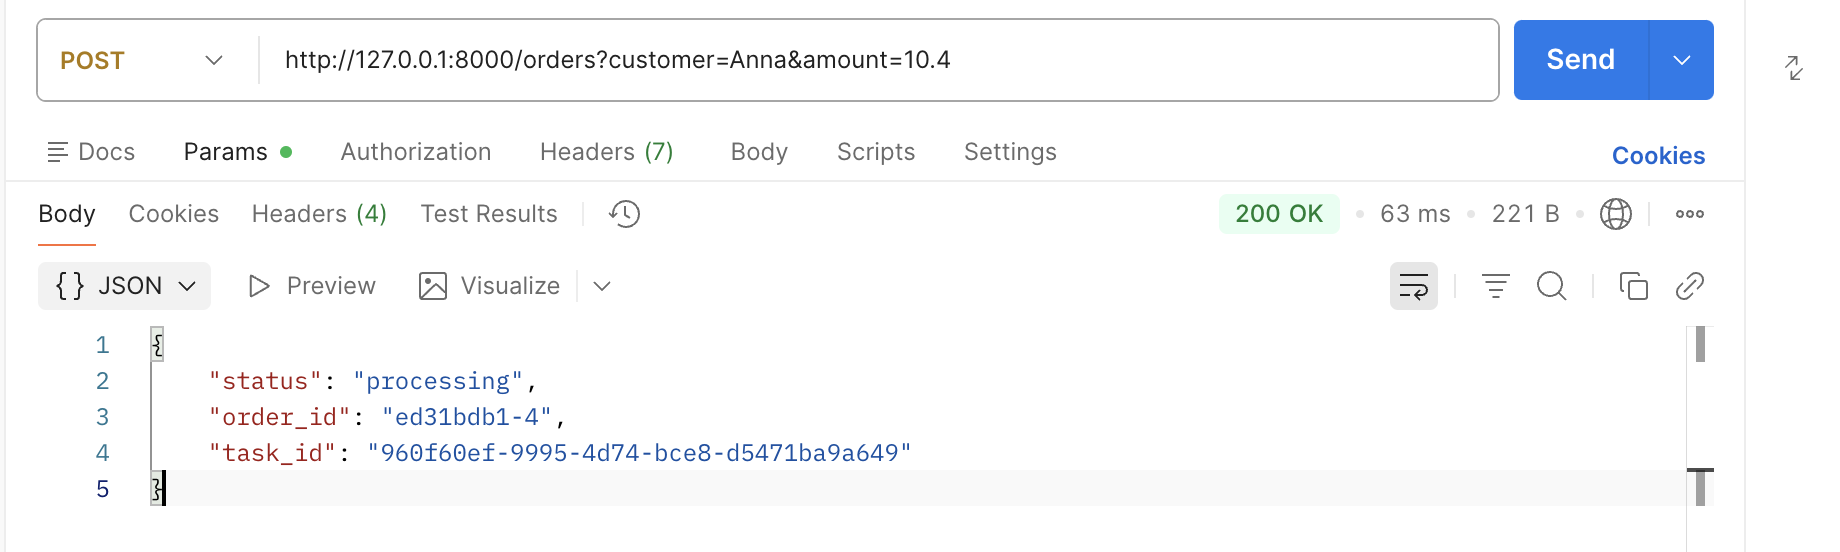

Still processing:   
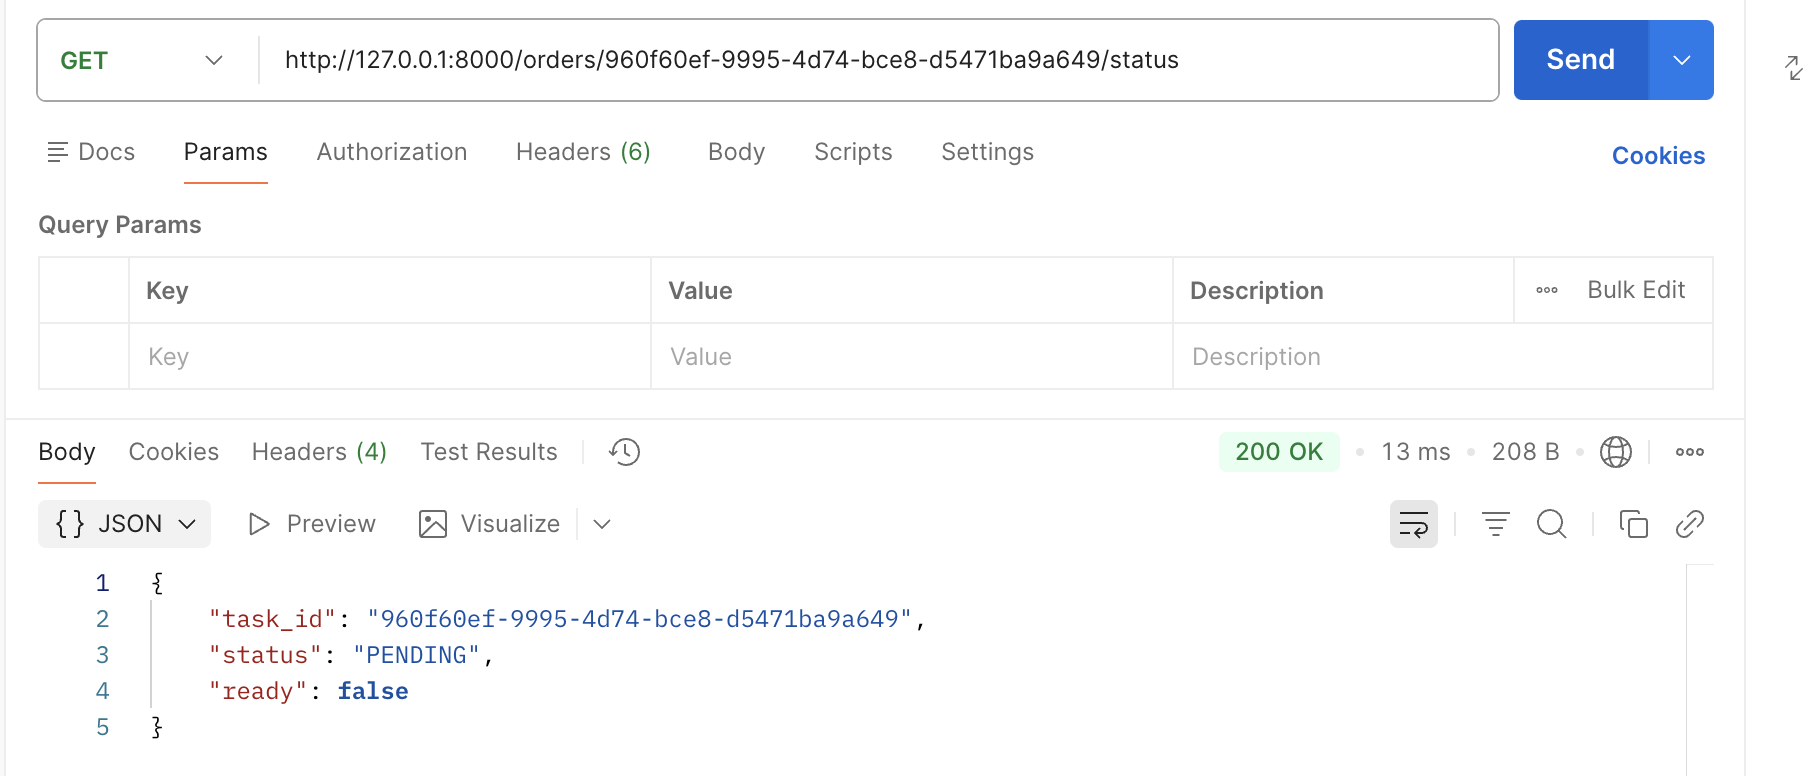

After it is done:  
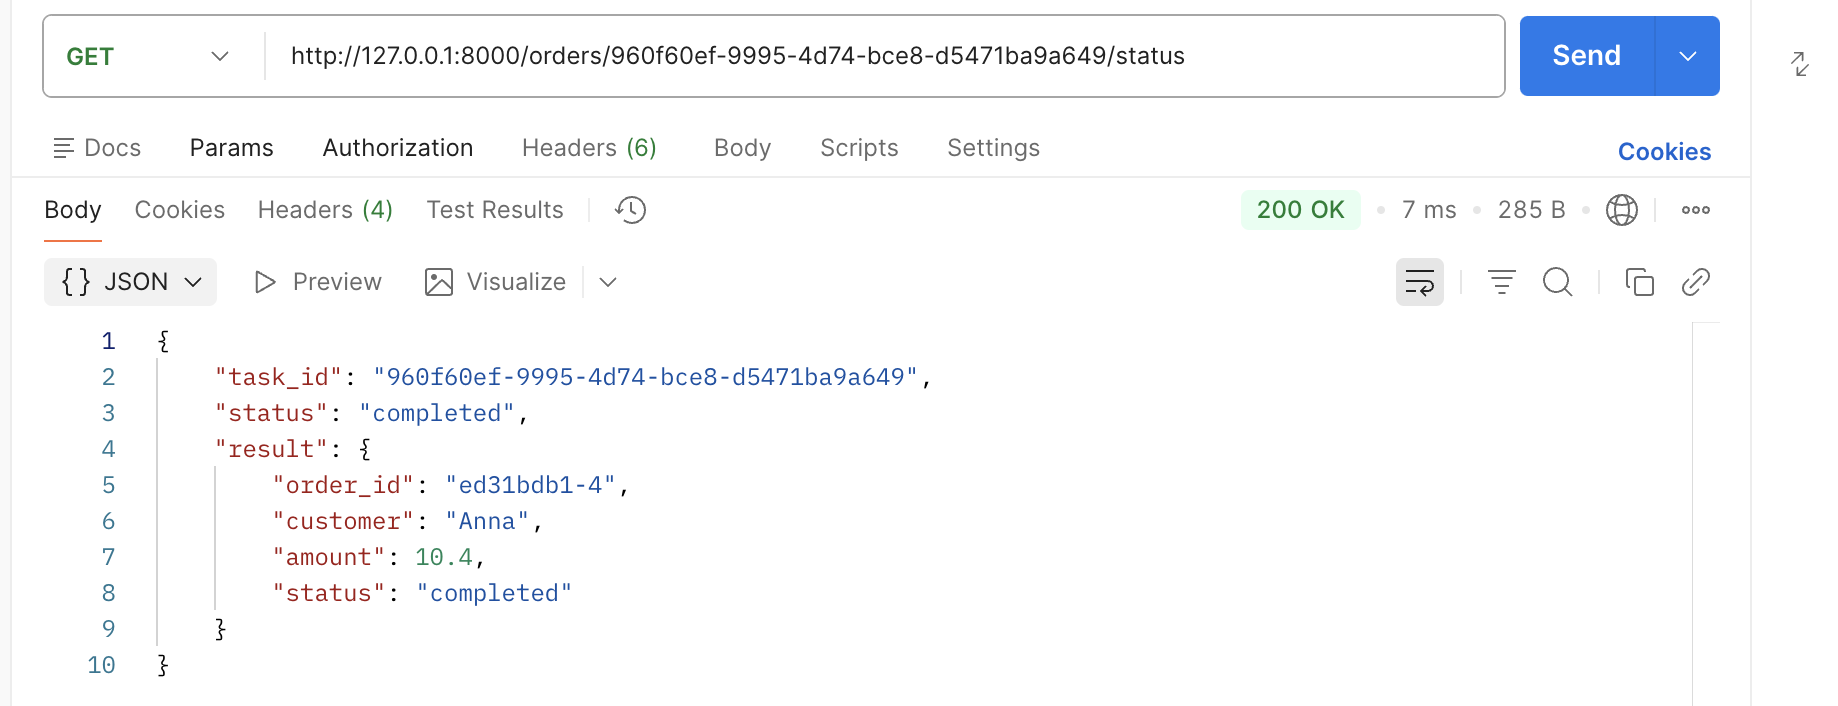


### result backends

#### `backend='rpc://'` (RPC Backend)  



- **RPC** = Remote Procedure Call    
- Uses **RabbitMQ itself** to store results
- Results stored **temporarily** in RabbitMQ queues   

Task completes → Result sent back to RabbitMQ → Client retrieves result    

Pros ✅   

- No extra dependency - only need RabbitMQ (no Redis needed)    
- Simple setup - one service to manage    
- Good for simple cases    

Cons ❌       

- Not persistent - results lost if RabbitMQ restarts       
- Limited features - can't query old results      
- Harder to debug - can't inspect results directly        
- Result expiration issues - results disappear quickly      
- **Not recommended for production**       

Use Cases            

- Quick prototypes             
- Don't care about results     
- Fire-and-forget tasks      
- Learning/testing Celery        



#### `backend='redis://localhost:6379/0'` (Redis Backend)       



- Uses Redis as a separate result storage         
- Results stored in **Redis database** (index 0)      
- **Persistent and queryable**       

Task completes → Result stored in Redis → Client retrieves from Redis anytime        

Pros ✅      
 
- Persistent - results survive restarts (if Redis persistence enabled)
- Rich features - TTL, querying, inspection
- Production-ready - widely used
- Easy debugging - can inspect results directly with redis-cli
- Better performance for result retrieval
- Configurable expiration - control how long results are kept

Cons ❌        

- Extra dependency - need Redis running
- More setup - one more service to manage
- Uses more resources - Redis + RabbitMQ
 
Use Cases       

- **Production applications** (recommended!)
- Need to check results later
- Multiple workers/servers
- Need result persistence
- Building real applications

### Retry Mechanism with Exponential Backoff

- Celery automatically moves failed tasks to DLQ after max_retries    
- Configure in broker (RabbitMQ/SQS)   

**Exponential Backoff** = Delay between retries increases exponentially

```text
Attempt 1: Immediate
Attempt 2: Wait 2^1 = 2 seconds
Attempt 3: Wait 2^2 = 4 seconds
Attempt 4: Wait 2^3 = 8 seconds
```

**Why?**
- Avoid overwhelming failing service
- Give system time to recover
- Reduce resource waste

**Implementation**:
```python
@app_celery.task(
    autoretry_for=(ConnectionError, TimeoutError),
    retry_kwargs={'max_retries': 5},
    retry_backoff=True,          # Enable exponential backoff
    retry_backoff_max=600,       # Max 10 minutes between retries
    retry_jitter=True            # Add randomness to avoid thundering herd
)
def risky_task():
    # Task that might fail
    pass
```



### Idempotency in Message Processing

**Idempotent** = Operation can be applied multiple times with same result

**Why Important?**
- Messages might be delivered multiple times
- Worker might crash mid-processing
- Network issues can cause duplicates

**Implementation**:
```python
def process_order(order_id, customer, amount):
    # Check if already processed
    if redis_client.get(f'processed:{order_id}'):
        return {'status': 'already_processed'}
    
    # Process order
    result = do_processing(order_id, customer, amount)
    
    # Mark as processed (atomic operation)
    redis_client.set(f'processed:{order_id}', '1', ex=86400)  # 24hr TTL
    
    return result
```



## Message Queue Best Practices

1. **Always make consumers idempotent**
2. **Set appropriate TTL on messages**
3. **Configure dead letter queues**
4. **Monitor queue depth** (if growing, add workers)
5. **Use task priorities** for urgent tasks
6. **Implement circuit breakers** for external dependencies
7. **Log task failures** for debugging
8. **Set timeouts** to prevent stuck tasks

---



# [System Design Interview](./system-design.md)  
This session’s content can likely be asked when discussing System Design in interviews.    
You need to understand which solution fits which scenario and requirements. 

The 9-Phase System Design Framework

## PHASE 1: Problem Clarification & Scope (5 minutes)

**MOST IMPORTANT**: Clarify functional & non-functional requirements   
- What to focus (MVP features)
- What can be skip for now

**Must-Ask Questions**:
- **Features**: What's MVP vs future features?
- **Scale**: How many users? (1K, 100K, 1M, 100M?)
- **Usage Pattern**: Read-heavy or write-heavy?
- **Real-time Need**: Real-time updates or eventual consistency?
- **Data Loss Tolerance**: Can we lose 1 hour of data? Forever?

**Example**:

Interviewer: Design Instagram   

You: Let me clarify:    
- MVP: Upload photos, follow users, see feed?   
- Scale: 100M users, 50M DAU?   
- Read-heavy (viewing) or write-heavy (uploading)?   
- Real-time feed updates needed?    
- Can we lose uploaded photos? No? Need replication.     




## PHASE 2: Capacity Estimation (5 minutes)

**Calculate**:
- DAU (Daily Active Users)
- RPS (Requests Per Second)
- Data volume (Storage)

**Common Reference Numbers**:
- 1 server handles ~1,000 RPS
- At 600 RPS → Need 2-3 servers minimum
- Single database fine until 100M+ data rows (M: million)
- Storage estimate: (Users × Data per user per day × 365 × Years)

**Example**:

50M DAU, each user views 20 photos/day    
= 50M × 20 = 1B photo views/day      
= 1B / 86,400 seconds ≈ 11,600 RPS       
→ Need ~12-15 servers for photo serving       

megabytes (MB)   
megabits (Mb)



## PHASE 3: High-Level Architecture (10 minutes)
(call back the cache, top5 caching patterns, and message queue)    

**Always Include**:
- Load Balancer
- App Servers
- Cache Layer
- Database
- Message Queue (if necessary)

**Basic Architecture**:
```text
[User] → [DNS] → [Load Balancer] 
                     ↓
              [App Servers x3]
                     ↓
         ┌───────────┼───────────┐
         ↓           ↓           ↓
    [Cache]     [Database]   [Queue]
```



## ⭐️ PHASE 4: Data Model & Schema (10 minutes)
This is the key part. Better to know database design/ UML design.  

**MUST HAVE**:
- SQL schema with proper data types
- Primary keys (id, UUID)
- Indexes (on frequently queried columns)
- Foreign keys (relationships)
- Relationship types (1-1, 1-many, many-many)

**Example**:
```sql
CREATE TABLE users (
    id BIGINT PRIMARY KEY AUTO_INCREMENT,
    username VARCHAR(50) UNIQUE NOT NULL,
    email VARCHAR(100) UNIQUE NOT NULL,
    created_at TIMESTAMP DEFAULT NOW(),
    INDEX idx_username (username),
    INDEX idx_email (email)
);
```



## PHASE 5: API Design (5 minutes)

**MUST-HAVE Endpoints**:
- Restful or
- GraphQL (most likely not needed)

**API Decisions**:  
- RESTful style (most common)
- Request & Response structure in JSON
- Pagination: Use `limit` + `offset` or cursor
- Error codes if asked
- Rate limiting if needed (e.g. 5 requests/second, for reliability of the system)

**Example**:
```html
POST   /api/v1/posts
GET    /api/v1/posts/{id}
GET    /api/v1/feed?limit=20&cursor=xyz
POST   /api/v1/users/{id}/follow
DELETE /api/v1/users/{id}/follow
GET    /api/v1/users/{id}/followers?limit=50&offset=0
```

**Response Structure**:
```json
{
  "data": {
    "posts": [...],
    "cursor": "next_page_token"
  },
  "meta": {
    "total": 1000,
    "limit": 20
  }
}
```

## PHASE 6: Caching Strategy (5 minutes)

**Use [Cache Decision Tree](#cache-decision-tree)** (from earlier section)

**Most Common**: Cache-Aside pattern
- Cache user profiles
- Cache news feeds
- Cache popular posts

```python
# Cache user profile (changes infrequently)
def get_user(user_id):
    cached = redis.get(f'user:{user_id}')
    if cached:
        return cached
    user = db.query(user_id)
    redis.set(f'user:{user_id}', user, ttl=3600)
    return user
```

## PHASE 7: Scaling Strategies (10 minutes)

**Scenario 1: Traffic Increases 10x**
- Add more app servers (horizontal scaling)
- Add cache layer for frequent queries
- Add message queue to offload heavy work

**Scenario 2: Database Too Slow**
- Add indexes on frequently queried columns
- Cache frequent queries
- Add read replicas (for read-heavy workloads)
- Eventually: Shard by user_id

**Scenario 3: One Server Dies**
- Load balancer health checks
- Automatically stops sending traffic to dead server
- Auto-scaling groups provision new server

**Scenario 4: Real-Time Updates Needed**
- Use WebSockets for push notifications
- Or use Server-Sent Events (SSE) for one-way updates



## 💡 PHASE 8: Monitoring & Alerting (5 minutes)
This differs you with other developers.  

**MUST-HAVE Metrics**:

**1. API Response Time**
- Track P50, P95, P99 latencies
- Alert if P95 > 500ms

**2. Request Throughput**
- Track RPS
- Alert if drops suddenly (outage)
- Alert if spikes beyond capacity

**3. Error Rate**
- Alert if > 3% errors
- Track 4xx (client errors) vs 5xx (server errors)

**4. Resource Metrics**
- CPU usage (alert if > 80%)
- Memory usage
- Disk space

**5. Database Metrics**
- Query latency
- Connection pool usage
- Slow query log

**6. Cache Metrics**
- Hit ratio (should be > 80%)
- Eviction rate

**Monitoring Tools**:
- Metrics: Datadog, New Relic, Prometheus
- Logging: Datadog, Splunk, ELK Stack
- Alerting: PagerDuty, Opsgenie



## PHASE 9: Trade-offs Discussion (5 minutes)

**For Each Major Decision**:
```
Option A:
Pros: X, Y, Z
Cons: A, B, C
When to use: [scenario]

Option B:
Pros: X, Y, Z
Cons: A, B, C
When to use: [scenario]
```

**Common Trade-Offs**:

**1. Consistency vs Availability (CAP Theorem)**
- Strong consistency: All nodes see same data (SQL)
- Eventual consistency: Nodes sync eventually (NoSQL)

**2. SQL vs NoSQL**
- SQL: Structured, ACID, relations
- NoSQL: Flexible schema, horizontal scaling

**3. REST vs GraphQL**
- REST: Simple, standard, cacheable
- GraphQL: Flexible queries, single endpoint

**4. Synchronous vs Asynchronous**
- Sync: Immediate response, simpler
- Async: Better performance, more complex



## Quick Decision Matrix

| Decision | Default Choice | Why |
|----------|----------------|-----|
| Database | SQL (PostgreSQL) | Simple, relational, scalable to 100M+ |
| Cache | Redis | Fast, simple, TTL support, many data structures |
| API | REST | Easiest to explain, industry standard |
| Load Balancer | Round-robin | Works well for most cases |
| Message Queue | Skip unless needed | Don't over-engineer for smaller scales |
| Sharding | Skip | Only needed at 100M+ users |
| Microservices | Skip | Too complex for interview scope |
| CDN | Mention briefly | For static files if global users |



##  Final Interview Checklist

Before ending the interview, ensure you've covered:

- ✅ Asked clarifying questions
- ✅ Drew a clear diagram
- ✅ Discussed performance/scalability
- ✅ Mentioned trade-offs
- ✅ Considered edge cases
- ✅ Thought about monitoring

---



# Summary

This guide covers four critical areas of advanced web development:

1. **WebSockets**: Real-time, bidirectional communication for chat, live updates, and collaborative apps
2. **Caching**: Redis-based strategies (cache-aside, write-through, etc.) to reduce latency and database load
3. **Message Queues**: Celery + RabbitMQ for asynchronous task processing with retry logic and idempotency
4. **System Design**: Complete framework for interviews covering architecture, scaling, monitoring, and trade-offs

**Key Takeaways**:
- Use WebSockets for real-time needs, HTTP for occasional updates
- Cache frequently read, slowly changing data with cache-aside pattern
- Use message queues to decouple services and handle background tasks
- In system design, always clarify requirements, calculate capacity, and discuss trade-offs

